## Importing and cleaning data

In [76]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

transaction_history_1 = pd.read_csv("../transaction_history_csv/sep-dec.csv")
transaction_history_2 = pd.read_csv("../transaction_history_csv/jun-sep.csv")
transaction_history = pd.concat([transaction_history_1, transaction_history_2])
transaction_history = transaction_history.drop('Unnamed: 7', axis=1)

transaction_history["Transaction Date"] = pd.to_datetime(transaction_history["Transaction Date"])
transaction_history["Debit Amount"] = transaction_history["Debit Amount"].replace({' ': np.nan})
transaction_history["Debit Amount"] = transaction_history["Debit Amount"].astype(float)
transaction_history["Credit Amount"] = transaction_history["Credit Amount"].replace({' ': np.nan})
transaction_history["Credit Amount"] = transaction_history["Credit Amount"].astype(float)
transaction_history["Date"] = transaction_history["Transaction Date"].dt.strftime('%b %d')
transaction_history["Month"] = transaction_history["Transaction Date"].dt.strftime('%m %b')
transaction_history["Transaction Ref1"] = transaction_history["Transaction Ref1"].fillna("")
transaction_history["Transaction Ref2"] = transaction_history["Transaction Ref2"].fillna("")
transaction_history["Transaction Ref3"] = transaction_history["Transaction Ref3"].fillna("")
transaction_history["Vendor"] = transaction_history["Transaction Ref1"] + ' ' + transaction_history["Transaction Ref2"] + ' ' + transaction_history["Transaction Ref3"]
transaction_history = transaction_history[transaction_history["Reference"] != "ITR"]

output_directory = "../transaction_history_csv/out.csv"

transaction_history

,Transaction Date,Reference,Debit Amount,Credit Amount,Transaction Ref1,Transaction Ref2,Transaction Ref3,Date,Month,Vendor
0,2024-12-21,ICT,500.00,NaN,PayNow Transfer 8920040,To: CATALAN KWYNNZIE CHAVEZ,OTHR PayNow Transfer,Dec 21,12 Dec,PayNow Transfer 8920040 To: CATALAN KWYNNZIE C...
1,2024-12-21,ICT,NaN,485.0,Incoming PayNow Ref 1590093,From: CATALAN KWYNNZIE CHAVEZ,OTHR OTHR,Dec 21,12 Dec,Incoming PayNow Ref 1590093 From: CATALAN KWYN...
2,2024-12-21,UMC-S,5.76,NaN,SHENGSIONG@417FERNVALE SI NG 19DEC,5264-7110-0390-7302,,Dec 21,12 Dec,SHENGSIONG@417FERNVALE SI NG 19DEC 5264-7110-0...
3,2024-12-21,UMC-S,15.00,NaN,KOPITIAM @VIVO SI NG 19DEC,5264-7110-0390-7302,,Dec 21,12 Dec,KOPITIAM @VIVO SI NG 19DEC 5264-7110-0...
4,2024-12-21,UMC-S,18.00,NaN,STUFF'D COMPASS ONE SI NG 18DEC,5264-7110-0390-7302,,Dec 21,12 Dec,STUFF'D COMPASS ONE SI NG 18DEC 5264-7110-0...
...,...,...,...,...,...,...,...,...,...,...
122,2024-06-29,UMC-S,48.80,NaN,ASTONS-KALLANG SI NG 27JUN,5264-7110-1009-8095,,Jun 29,06 Jun,ASTONS-KALLANG SI NG 27JUN 5264-7110-1...
123,2024-06-29,UMC-S,2.00,NaN,HANA FILM PTE LTD SI NG 27JUN,5264-7110-1009-8095,,Jun 29,06 Jun,HANA FILM PTE LTD SI NG 27JUN 5264-7110-1...
124,2024-06-29,UMC-S,11.35,NaN,MCDONALD'S (CP1) SI NG 25JUN,5264-7110-1009-8095,,Jun 29,06 Jun,MCDONALD'S (CP1) SI NG 25JUN 5264-7110-1...
125,2024-06-29,UMC-S,10.60,NaN,MCDONALD'S (CP1) SI NG 25JUN,5264-7110-1009-8095,,Jun 29,06 Jun,MCDONALD'S (CP1) SI NG 25JUN 5264-7110-1...


## Categorizing vendors

In [77]:
def remove_special_characters(string):
    return "".join(e for e in string.lower() if e.isalnum())

def check_if_string_in_list(original_string, reference_list):
    if not isinstance(original_string, str):
        return False
    original_list = [remove_special_characters(s) for s in re.split("\\s+|\.|\@|\*|\/|\_|\-", original_string)]
    return any([x in reference_list for x in original_list])

def categorize_vendors(original_string, reference_dict):
    if not isinstance(original_string, str):
        return "Others"
    original_list = [remove_special_characters(s) for s in re.split("\\s+|\.|\@|\*|\/|\_|\-", original_string)]
    for x in original_list:
        for key, value in reference_dict.items():
            if x in value:
                return key
    return "Shopping"

# F&B vendors list
with open("../restaurants.txt") as restaurants:
    lines = restaurants.readlines()

    restaurant_list = []
    for line in lines:
        line = [remove_special_characters(e) for e in line.split(", ")]
        restaurant_list.extend(line)

    restaurant_list = list(set(restaurant_list))

# Transport vendors list
# Transport, transfers, salary, and medical lists
transport_list = ["bus", "grab"]
# transfer_list = ["paynow", "transfer", "ref", "bank", "revolut"]
transfer_list = ["kwynnzie"]
salary_list = ["mindef", "saf", "gov"]
medical_list = ["polyclinic", "clinic"]

# Vendor group dictionary
vendor_groups = {
    "F&B": restaurant_list,
    "Transport": transport_list,
    "Transfers": transfer_list,
    "Salary": salary_list,
    "Medical": medical_list
}

# Transportation vendors list
transaction_history["Category"] = transaction_history["Vendor"].apply(lambda x: categorize_vendors(x, vendor_groups))
output_directory = "../transaction_history_csv/out.csv"
transaction_history["Category"].value_counts()

Category
Shopping     131
F&B           83
Transport     59
Transfers     49
Salary         7
Name: count, dtype: int64

In [78]:
def get_price_range(df, upper, lower=-np.inf):
    return df[(df["Debit Amount"] < upper) & (df["Debit Amount"] > lower)] 

def get_category(df, category):
    return df[df["Category"]==category]

def get_shopping_and_fb_categories(df):
    return df[(df["Debit Amount"].notna()) & (df["Category"].isin(["Shopping", "F&B"]))]

def output_csv(df, directory=output_directory):
    df.to_csv(directory, index=False)

def plot_catplot(df):
    df = get_shopping_and_fb_categories(df)

    month_axis_ordering = sorted(transaction_history["Month"].unique())
    sns.catplot(data=df, x="Month", y="Debit Amount", order=month_axis_ordering)

def plot_debit_amount(df):
    df[["Transaction Date", "Debit Amount"]].set_index("Transaction Date").plot.line()

def plot_monthly_debit_spending(df):
    df = df[df["Debit Amount"].notna()]
    ax = df[["Month", "Debit Amount"]].groupby("Month").sum().plot.bar()
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

def plot_spending_histogram(df, bins_count=100):
    df["Debit Amount"].plot.hist(bins=bins_count)

def plot_number_of_transactions_monthly(df):
    df = df[df["Debit Amount"].notna()]
    ax = df[["Month", "Debit Amount"]].groupby("Month").count().plot.bar()
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


In [79]:
output_csv(transaction_history, "../transaction_history_csv/cleaned_transaction_history.csv")

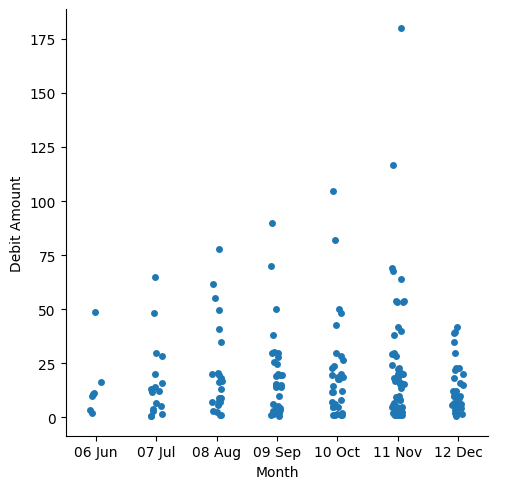

In [80]:
plot_catplot(transaction_history)

In [81]:
df = get_shopping_and_fb_categories(transaction_history[transaction_history["Category"]=="F&B"])
df = df[['Month', 'Debit Amount']].groupby('Month').agg(['mean', 'median', 'sum', 'count'])
df.columns = df.columns.droplevel()
df.transpose()

Month,06 Jun,07 Jul,08 Aug,09 Sep,10 Oct,11 Nov,12 Dec
mean,23.583333,15.33625,17.925,15.056875,12.797333,14.241154,10.328571
median,11.350000,13.15000,11.100,14.350000,8.150000,9.300000,12.000000
sum,70.750000,122.69000,143.400,240.910000,191.960000,370.270000,72.300000
count,3.000000,8.00000,8.000,16.000000,15.000000,26.000000,7.000000


## Total spending over time

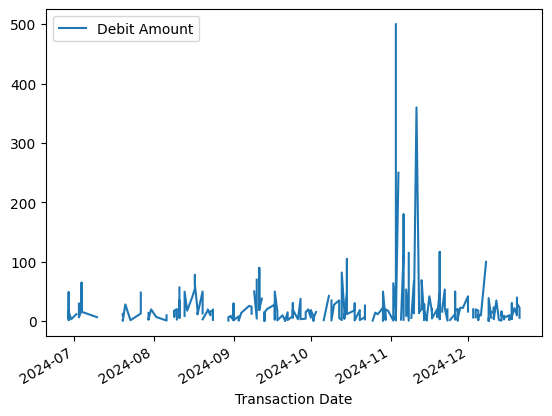

In [82]:
plot_debit_amount(transaction_history)

## Spending on F&B over time

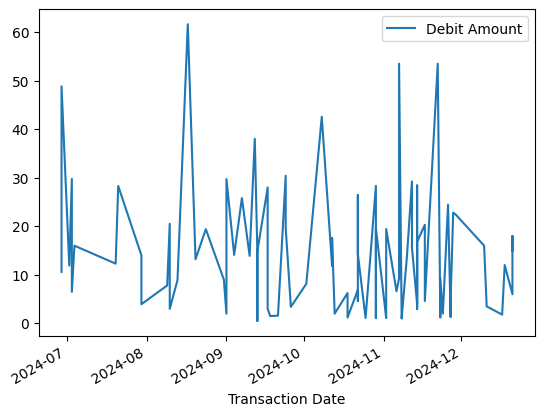

In [83]:
plot_debit_amount(get_category(transaction_history, "F&B"))

## Histogram of total spending

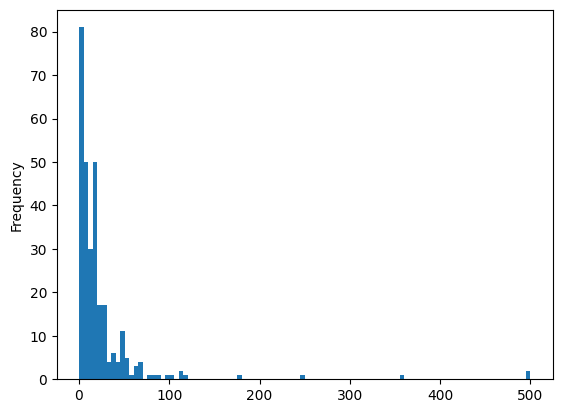

In [84]:
plot_spending_histogram(transaction_history)

## Histogram of spending on F&B

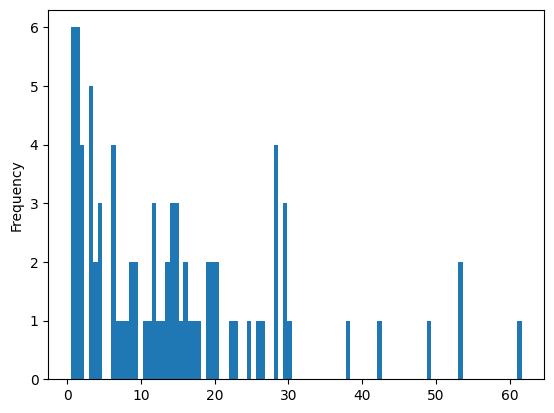

In [85]:
plot_spending_histogram(get_category(transaction_history, "F&B"))

## Monthly spending 

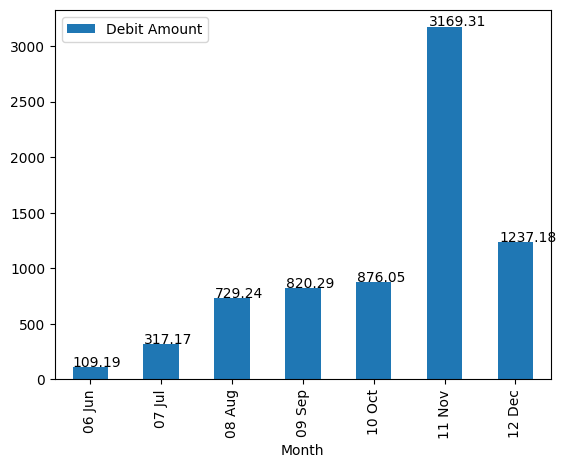

In [86]:
plot_monthly_debit_spending(transaction_history)

## Monthly F&B spending

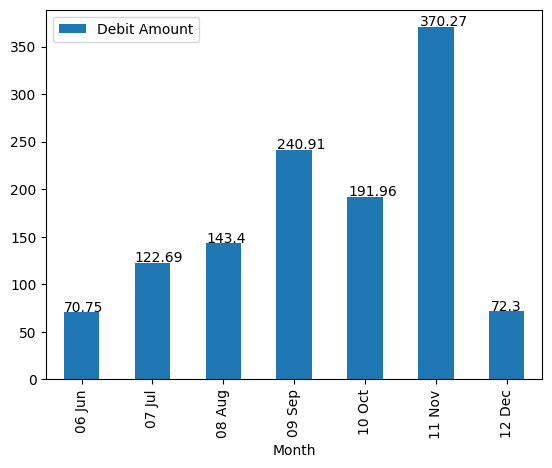

In [87]:
plot_monthly_debit_spending(get_category(transaction_history, "F&B"))

## Monthly total count of transactions

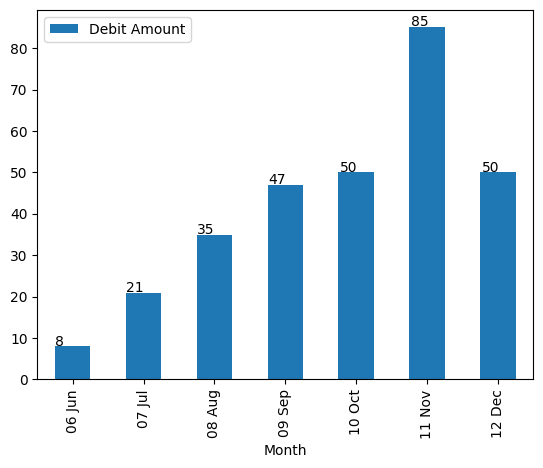

In [88]:
plot_number_of_transactions_monthly(transaction_history)

## Monthly count of transactions on F&B

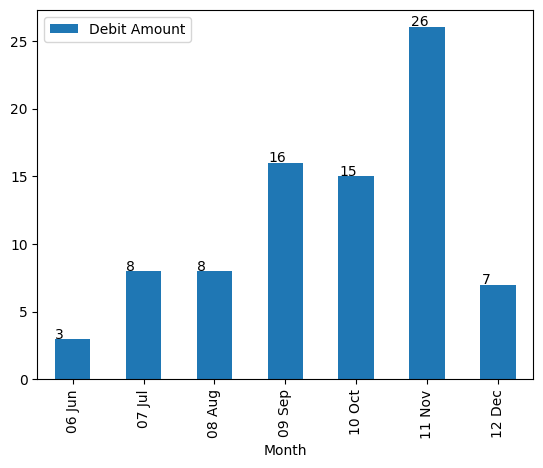

In [89]:
plot_number_of_transactions_monthly(get_category(transaction_history, "F&B"))

## Price bands

In [90]:
df = get_category(transaction_history, "Others")

price_bands = {
    "0-10": float(get_price_range(df, 10)["Debit Amount"].sum()),
    "10-20": float(get_price_range(df, 20, 10)["Debit Amount"].sum()),
    "20-30": float(get_price_range(df, 30, 20)["Debit Amount"].sum()),
    "30-40": float(get_price_range(df, 40, 30)["Debit Amount"].sum()),
    "40-50": float(get_price_range(df, 50, 40)["Debit Amount"].sum()),
    "50+": float(get_price_range(df, np.inf, 50)["Debit Amount"].sum())
}

price_bands

{'0-10': 0.0,
 '10-20': 0.0,
 '20-30': 0.0,
 '30-40': 0.0,
 '40-50': 0.0,
 '50+': 0.0}

In [91]:
df = transaction_history[transaction_history["Debit Amount"].notna()]
df[["Category", "Debit Amount"]].groupby("Category").agg(["mean", "median", "sum", "count"]).round(2)

Debit Amount                      
                  mean median      sum count
Category                                    
F&B              14.61   12.0  1212.28    83
Shopping         22.26   13.0  2782.09   125
Transfers        84.34   22.0  2445.82    29
Transport        13.87   12.2   818.24    59

<Axes: xlabel='Month', ylabel='Debit Amount'>

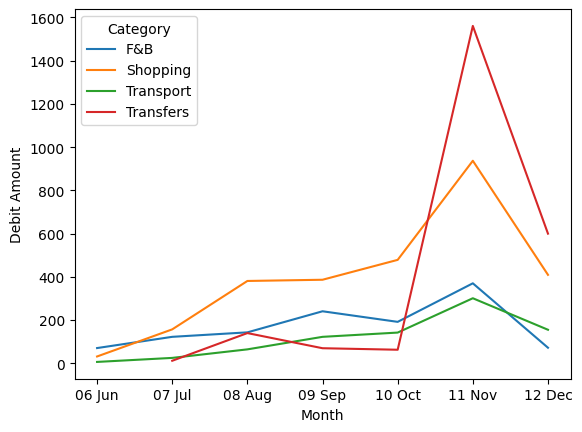

In [92]:
df = transaction_history[transaction_history["Debit Amount"].notna()][["Month", "Category", "Debit Amount"]].groupby(["Month", "Category"]).sum()
sns.lineplot(data=df.reset_index(), x="Month", y="Debit Amount", hue="Category")

<Axes: xlabel='Category', ylabel='Debit Amount'>

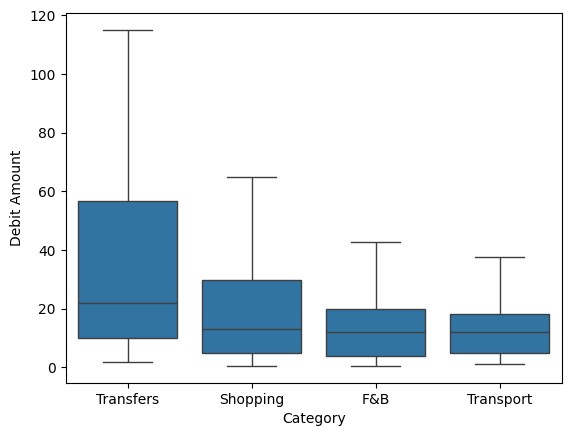

In [93]:
df = transaction_history[transaction_history["Debit Amount"].notna()]
sns.boxplot(data=df, x="Category", y="Debit Amount", showfliers=False)

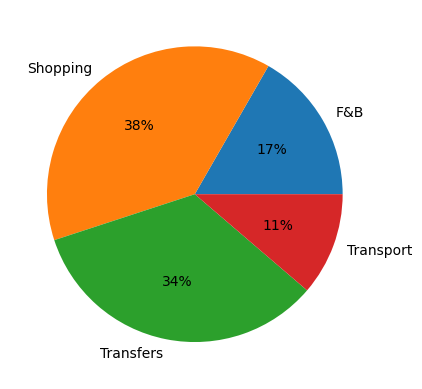

In [94]:
df = transaction_history[transaction_history["Debit Amount"].notna()][["Category", "Debit Amount"]].groupby("Category").sum()
plt.pie(df["Debit Amount"], labels=df.index,  autopct='%.0f%%')
plt.show()

In [95]:
import plotly.express as px

df = transaction_history[transaction_history["Debit Amount"].notna()][["Category", "Debit Amount"]].groupby("Category").sum()
fig = px.pie(df, values="Debit Amount", names=df.index)
fig.show()

In [96]:
df = transaction_history
df["In/Out"] = df["Category"].apply(lambda x: "In" if x == "Salary" else "Out")
df["Amount"] = df["Debit Amount"]
df["Amount"] = df["Amount"].fillna(-df["Credit Amount"])
df.loc[df["Category"]=="Salary", "Amount"] *= -1

df = df[["Month", "In/Out", "Amount"]].groupby(["Month", "In/Out"]).sum()

fig = px.bar(df.reset_index(), x="Month", y="Amount", color="In/Out", barmode="group", color_discrete_map={"In": "rgb(68, 170, 153)", "Out": "rgb(204, 102, 119)"})
fig.show()

In [97]:
px.box(transaction_history, x="Category", y="Debit Amount")

In [98]:
get_category(transaction_history, "F&B")["Debit Amount"].mean()

np.float64(14.605783132530117)

In [99]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

dining_transactions = transaction_history[transaction_history["Category"]=="F&B"]
trace1 = go.Box(x=dining_transactions["Month"], y=dining_transactions["Debit Amount"])

df = dining_transactions[dining_transactions["Debit Amount"].notna()][["Month", "Debit Amount"]].groupby(["Month"]).sum().reset_index()

# box_chart.add_bar(data=df, x="Month", y="Debit Amount")
trace2 = go.Scatter(x=df["Month"], y=df["Debit Amount"], text=df["Debit Amount"])

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2, secondary_y=True)

In [100]:
from sklearn.linear_model import LinearRegression

dining_transactions = transaction_history[transaction_history["Category"]=="Shopping"]
df = dining_transactions[['Month', 'Debit Amount']].groupby('Month').agg(['mean', 'median', 'sum', 'count'])[:-1]
df.columns = df.columns.droplevel()


X = df[["count", "median", "mean"]]
y = df["sum"].values

model = LinearRegression()
model.fit(X, y)

count_pred = np.array(range(0, 35, 2))
median_pred = np.array(range(0, 20, 1))
mean_pred = np.array(range(0, 35, 2))
pred = list(zip(count_pred, median_pred, mean_pred))

predictions = model.predict(pred)
trace1 = go.Scatter(x=list(range(0, 35, 2)), y=model.predict(pred), mode="lines")
trace2 = go.Scatter(x=df["count"], y=df["sum"], mode="markers")

fig = make_subplots()
fig.add_trace(trace1)
fig.add_trace(trace2)

c:\Users\brend\onedrive\Documents\expense-tracker\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

c:\Users\brend\onedrive\Documents\expense-tracker\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



In [101]:
l1 = np.array(range(0, 35, 2))
l2 = np.array(range(0, 20, 1))
l3 = np.array(range(0, 35, 2))
model.predict(list(zip(l1, l2, l3)))
# len(l2)

c:\Users\brend\onedrive\Documents\expense-tracker\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



array([ -85.36255023,  -17.06173109,   51.23908806,  119.5399072 ,
        187.84072634,  256.14154549,  324.44236463,  392.74318378,
        461.04400292,  529.34482206,  597.64564121,  665.94646035,
        734.24727949,  802.54809864,  870.84891778,  939.14973693,
       1007.45055607, 1075.75137521])

In [102]:
px.scatter(df, x="median", y="sum")

In [103]:
px.scatter(df, x="mean", y="sum")

In [104]:
output_csv(get_category(transaction_history, "F&B")[["Transaction Date", "Vendor", "Category", "Debit Amount"]])

In [105]:
transaction_history.shape[0]

329

In [106]:
transaction_history.drop_duplicates(subset=["Transaction Date", "Debit Amount", "Vendor"], keep=False).shape[0]

324

In [107]:
transaction_history.loc[transaction_history.duplicated(subset=["Transaction Date", "Debit Amount", "Vendor"])]

,Transaction Date,Reference,Debit Amount,Credit Amount,Transaction Ref1,Transaction Ref2,Transaction Ref3,Date,Month,Vendor,Category,In/Out,Amount
85,2024-11-20,UMC-S,8.0,NaN,ARCADE PLANET PTE LTD SI NG 16NOV,5264-7110-0390-7302,,Nov 20,11 Nov,ARCADE PLANET PTE LTD SI NG 16NOV 5264-7110-0...,Shopping,Out,8.0
86,2024-11-20,UMC-S,20.0,NaN,ARCADE PLANET PTE LTD SI NG 16NOV,5264-7110-0390-7302,,Nov 20,11 Nov,ARCADE PLANET PTE LTD SI NG 16NOV 5264-7110-0...,Shopping,Out,20.0
88,2024-11-20,UMC-S,20.0,NaN,ARCADE PLANET PTE LTD SI NG 16NOV,5264-7110-0390-7302,,Nov 20,11 Nov,ARCADE PLANET PTE LTD SI NG 16NOV 5264-7110-0...,Shopping,Out,20.0


In [108]:
transaction_history[transaction_history["Transaction Date"]=="2024-11-20"]

,Transaction Date,Reference,Debit Amount,Credit Amount,Transaction Ref1,Transaction Ref2,Transaction Ref3,Date,Month,Vendor,Category,In/Out,Amount
78,2024-11-20,ICT,NaN,450.0,Incoming PayNow Ref 1009034,From: CATALAN KWYNNZIE CHAVEZ,OTHR OTHR,Nov 20,11 Nov,Incoming PayNow Ref 1009034 From: CATALAN KWYN...,Transfers,Out,-450.00
79,2024-11-20,UMC-S,38.00,NaN,COW PLAY COW MOO SI NG 16NOV,5264-7110-0390-7302,,Nov 20,11 Nov,COW PLAY COW MOO SI NG 16NOV 5264-7110-0...,Shopping,Out,38.00
80,2024-11-20,UMC-S,3.48,NaN,SHENGSIONG@417FERNVALE SI NG 17NOV,5264-7110-0390-7302,,Nov 20,11 Nov,SHENGSIONG@417FERNVALE SI NG 17NOV 5264-7110-0...,Shopping,Out,3.48
81,2024-11-20,UMC-S,8.00,NaN,ARCADE PLANET PTE LTD SI NG 16NOV,5264-7110-0390-7302,,Nov 20,11 Nov,ARCADE PLANET PTE LTD SI NG 16NOV 5264-7110-0...,Shopping,Out,8.00
82,2024-11-20,UMC-S,116.80,NaN,MINISO - JEWEL SI NG 16NOV,5264-7110-0390-7302,,Nov 20,11 Nov,MINISO - JEWEL SI NG 16NOV 5264-7110-0...,Shopping,Out,116.80
83,2024-11-20,UMC-S,54.00,NaN,GOLDWOOD PTE LTD SI NG 16NOV,5264-7110-0390-7302,,Nov 20,11 Nov,GOLDWOOD PTE LTD SI NG 16NOV 5264-7110-0...,Shopping,Out,54.00
84,2024-11-20,UMC-S,20.00,NaN,ARCADE PLANET PTE LTD SI NG 16NOV,5264-7110-0390-7302,,Nov 20,11 Nov,ARCADE PLANET PTE LTD SI NG 16NOV 5264-7110-0...,Shopping,Out,20.00
85,2024-11-20,UMC-S,8.00,NaN,ARCADE PLANET PTE LTD SI NG 16NOV,5264-7110-0390-7302,,Nov 20,11 Nov,ARCADE PLANET PTE LTD SI NG 16NOV 5264-7110-0...,Shopping,Out,8.00
86,2024-11-20,UMC-S,20.00,NaN,ARCADE PLANET PTE LTD SI NG 16NOV,5264-7110-0390-7302,,Nov 20,11 Nov,ARCADE PLANET PTE LTD SI NG 16NOV 5264-7110-0...,Shopping,Out,20.00
87,2024-11-20,UMC-S,10.00,NaN,ARCADE PLANET PTE LTD SI NG 16NOV,5264-7110-0390-7302,,Nov 20,11 Nov,ARCADE PLANET PTE LTD SI NG 16NOV 5264-7110-0...,Shopping,Out,10.00
